# Assignment 4

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

The third part of this assignment will require you to use camera intrinsics to estimate the bounding box of a car.

---
### 4.1 Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from matplotlib import image
import numpy as np
import copy
import cv2

%matplotlib inline

In [2]:
def annotate(imgPath):
    %matplotlib tk
    image_points = []
    fig = plt.figure(figsize=(20,30))

    img = mpimg.imread(imgPath)

    def onclick(event):
        ix, iy = event.xdata, event.ydata
        print(ix, iy)
        image_points.append([ix, iy])

    cid = fig.canvas.mpl_connect('button_press_event', onclick)

    imgplot = plt.imshow(img)
    plt.show()
    return image_points

In [3]:
# obtained from running the above code
image_points = [[128.42279794, 587.98801301],
                [338.86040961, 733.91190432],
                [518.57720206, 571.09156244],
                [506.28887437, 380.62248327],
                [248.23399291, 334.54125443],
                [321.96395904, 217.80214139]]

In [4]:
def show2DProjections(image_points, imgPath):
    N = len(image_points)
    image_points = np.array(image_points)
    fig = plt.figure(figsize=(10,15))

    img=mpimg.imread(imgPath)
    imgplot = plt.imshow(img)

    colors = np.random.rand(N)
    area = (15 * np.ones(N))**2 

    plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
    plt.show()

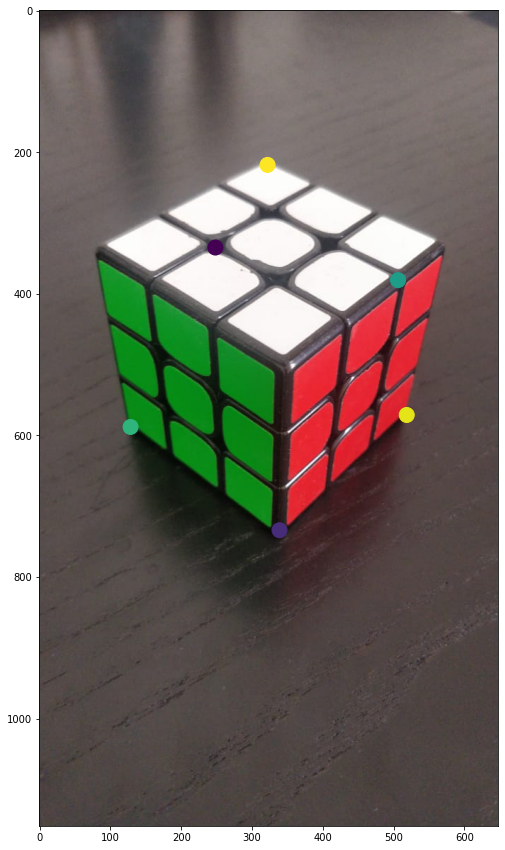

In [5]:
show2DProjections(image_points, 'q1/dlt1.jpeg')

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [6]:
# 2d correspondences
x = image_points

# 3d world coordinates (origin taken as bottom left corner of cube)
X = []
X.append([0, 0, 0])
X.append([3, 0, 0])
X.append([3, 0, -3])
X.append([3, 3, -2])
X.append([1, 3, -1])
X.append([0, 3, -3])

Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [7]:
def DLT(x, X):
    A = []
    
    for (xi, yi), (Xi, Yi, Zi) in zip(x, X):
        A.append([Xi, Yi, Zi, 1, 0, 0, 0, 0, -Xi * xi, -Yi * xi, -Zi * xi, -xi])
        A.append([0, 0, 0, 0, Xi, Yi, Zi, 1, -Xi * yi, -Yi * yi, -Zi * yi, -yi])
    
    A = np.array(A)
    U, D, VT = np.linalg.svd(A)
    P = VT[-1, :].reshape(3, 4)
    P /= P[-1, -1]
    return P

In [8]:
P = DLT(x, X)
print("P = \n", P)

P = 
 [[ 5.96215610e+01 -2.39059584e+01 -8.14591802e+01  1.28304064e+02]
 [ 2.56296126e+01 -1.09150208e+02  1.90055288e+01  5.87827573e+02]
 [-3.14396318e-02 -7.47308263e-02 -5.27283097e-02  1.00000000e+00]]


### Theory

- Explain how DLT is implemented and show why it works (proof)
- When does DLT fail?

$ x = PX $  
Here X is a 3D point in the world frame and x is its 2D projection.  
x and X are both in homogeneous coordinates.

Writing this equation in matrix form,

$
\begin{bmatrix}
    x_{i}        \\
    y_{i}  \\
    z_{i}
\end{bmatrix}
= 
\begin{bmatrix}
    p_{11}  &  p_{12} & p_{13}  &  p_{14}     \\
    p_{21}  &  p_{22} & p_{23}  &  p_{24}     \\  
    p_{31}  &  p_{32} & p_{33}  &  p_{34}     
\end{bmatrix} 
\begin{bmatrix}
    X_{i}        \\
    Y_{i}  \\
    Z_{i}   \\
    1
\end{bmatrix} 
$

After Matrix multiplication, we get:

$$ x_{i} =  p_{11}*X_{i} +   p_{12}*Y_{i} + p_{13}*Z_{i}  +  p_{14} $$
$$ y_{i} =  p_{21}*X_{i} +   p_{22}*Y_{i} + p_{23}*Z_{i}  +  p_{24} $$
$$ z_{i} =  p_{31}*X_{i} +   p_{32}*Y_{i} + p_{33}*Z_{i}  +  p_{34} $$

We know that
$
\begin{bmatrix}
    x_{i}        \\
    y_{i}  \\
    z_{i}
\end{bmatrix}
= 
z{i} \cdot \begin{bmatrix}
    x_{i} \over z_{i}      \\
    y_{i} \over z{i} \\
    1
\end{bmatrix}
= 
\begin{bmatrix}
    x_{i} \over z_{i}      \\
    y_{i} \over z{i} \\
    1
\end{bmatrix}
$
since we are dealing with projections.

So, $ x_{i} = \frac{x_{i}}{z_{i}}$ and $ y_{i} = \frac{y_{i}}{z_{i}}$

Our equations now become:
$$ x_{i} =  \frac{p_{11}*X_{i} +   p_{12}*Y_{i} + p_{13}*Z_{i}  +  p_{14}}
                 {p_{31}*X_{i} +   p_{32}*Y_{i} + p_{33}*Z_{i}  +  p_{34}} $$
$$ y_{i} =  \frac{p_{21}*X_{i} +   p_{22}*Y_{i} + p_{23}*Z_{i}  +  p_{24}}
                 {p_{31}*X_{i} +   p_{32}*Y_{i} + p_{33}*Z_{i}  +  p_{34}} $$

We write the above equations in matrix form:

$
\begin{bmatrix}
   X_{i} & Y_{i} & Z_{i} & 1 & 0 & 0 & 0 & 0 & -X_{i}*x_{i} & -Y_{i}*x_{i} & -Z_{i}*x_{i} &  -x_{i}       \\
   0 & 0 & 0 & 0 &  X_{i} & Y_{i} & Z_{i} & 1 & -X_{i}*y_{i} & -Y_{i}*y_{i} & -Z_{i}*y_{i} &  -y_{i} 
\end{bmatrix}
\begin{bmatrix}
    p_{11}  \\
      p_{12} \\
       p_{13} \\ 
         p_{14}     \\
    p_{21}  \\
      p_{22} \\
       p_{23}  \\
         p_{24}     \\  
    p_{31}  \\
      p_{32} \\
       p_{33}  \\
         p_{34}     
\end{bmatrix} 
= 
\begin{bmatrix}
    0 \\   
\end{bmatrix} 
$

Or

$$
A_{(2x12)}P_{(12x1)} = 0
$$

Hence, for each correspondence, we get 2 equations.  
If we have $n$ pairs of correspondences, A will have $ 2n $ rows.  
With >= 6 correspondences, we get an overdetermined homogeneous system of equations:
$$
A_{(2nx12)}P_{(12x1)} = 0
$$

We know that $P$ is a $3 \times 4$ matrix.  
Since we are solving an overdetermined homogenous system of equations, we anchor $P_{3, 4}$ to 1 and divide $P$ by $P_{3, 4}$.  
Hence, we have 11 unknowns.

To solve for $P$, we apply SVD on $A$ to get $A = UDV^T$.  
Since we are solving an overdetermined system, we minimize $||AP||^2$ to bring it close to 0.  
Substituting from the SVD equation:

$$
\begin{align}
||AP||^2 &= P^TA^TAP            \\
         &= P^T(VDU^T)(UDV^T)P  \\
         &= P^TVD^2V^TP         \\
\end{align}
$$

To minimize this equation, we set P to the vector in $V^T$ corresponding to the smallest eigenvalue in $D$. Hence, we get $P = V_{12}$.

Since P has 11 unknowns, we need at least 6 correspondences or 12 equations for DLT.  
We need at least 6 correspondences which map to unique projections in the image space.  
**Hence, DLT fails if we have less than 6 correspondences available which map to unique projections**.

## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [9]:
X_hom = np.array(copy.deepcopy(X))
X_hom = np.hstack((X_hom, np.ones((X_hom.shape[0], 1))))

In [10]:
#Get reprojected points
def get_points(P, X):
    points = P @ X.T
    points /= points[-1]
    points = points.T[:, :-1]
    return points

#Get reprojection error
def get_err(x, X_hom, P):
    points = get_points(P, X_hom)
    return np.sum((points - x) ** 2) / points.shape[0]

In [11]:
print("Reprojection Error is:", get_err(x, X_hom, P))

Reprojection Error is: 0.10210671109909601


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [12]:
def ret_RKT(P):
    H = P[:, :-1]
    h = P[:, -1].reshape(3, 1)
    H_inv = np.linalg.inv(H)
    
    RT, K_inv = np.linalg.qr(H_inv)
    R = RT.T
    K = np.linalg.inv(K_inv)
    K /= K[-1, -1]
    T = -H_inv @ h
    
    return R, K, T

In [13]:
R, K, T = ret_RKT(P)
print("R = \n", R)
print("K = \n", K)
print("T = \n", T)

R = 
 [[-0.79902912 -0.08394714  0.59540351]
 [ 0.5058404  -0.62918808  0.59012529]
 [ 0.32508146  0.77270644  0.54520345]]
K = 
 [[ 973.32853147   29.68350775  449.80727   ]
 [  -0.         -960.11974375  678.78585502]
 [   0.            0.            1.        ]]
T = 
 [[6.60966691]
 [7.66257002]
 [4.16406895]]


#### Verifying the R, K, T Values

Use `np.isclose` to verify the matrix

In [14]:
# recover P from R, K, T
H = K @ R
h = (-K @ R @ T).reshape(-1, 1)
P_recovered = np.hstack((H, h))
P_recovered /= P_recovered[-1, -1]

print("Calculated P = \n", P)
print("Recovered P = \n", P_recovered)
print("Verification: \n", np.isclose(P, P_recovered))

Calculated P = 
 [[ 5.96215610e+01 -2.39059584e+01 -8.14591802e+01  1.28304064e+02]
 [ 2.56296126e+01 -1.09150208e+02  1.90055288e+01  5.87827573e+02]
 [-3.14396318e-02 -7.47308263e-02 -5.27283097e-02  1.00000000e+00]]
Recovered P = 
 [[ 5.96215610e+01 -2.39059584e+01 -8.14591802e+01  1.28304064e+02]
 [ 2.56296126e+01 -1.09150208e+02  1.90055288e+01  5.87827573e+02]
 [-3.14396318e-02 -7.47308263e-02 -5.27283097e-02  1.00000000e+00]]
Verification: 
 [[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


**Reproject the world points with P matrix you have obtained via DLT and visualize**

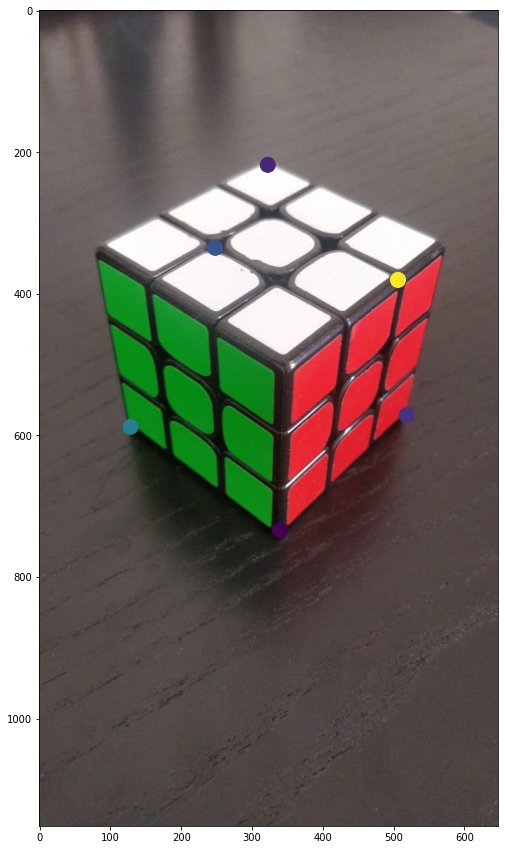

In [15]:
points = get_points(P, X_hom)
show2DProjections(points, 'q1/dlt1.jpeg')

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in `q1/zhangs` folder for this task. Familiarize yourself with the different parameters for this method.

**Reference**: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

### NOTE: DUE TO THE LARGE SIZE OF THE 'Zhangs' DIRECTORY, IT WAS OMITTED FROM THE SUBMITTED FILE. HENCE, COPY THE 'Zhangs' DIRECTORY TO 'q1' BEFORE RUNNING THE FOLLOWING CELLS.

Loading images...


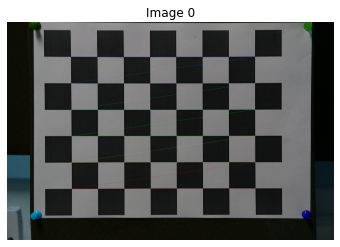

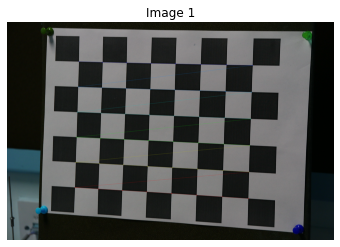

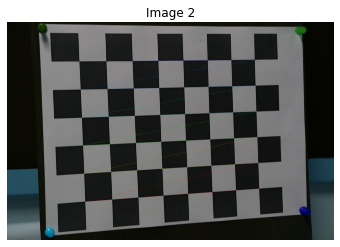

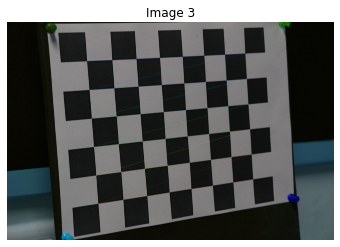

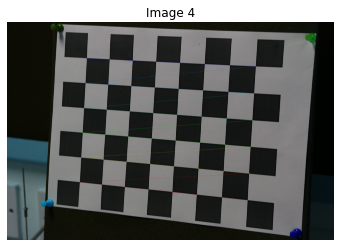

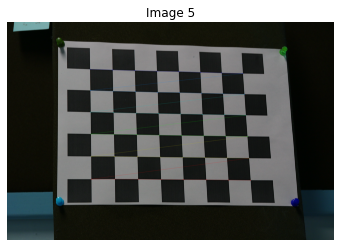

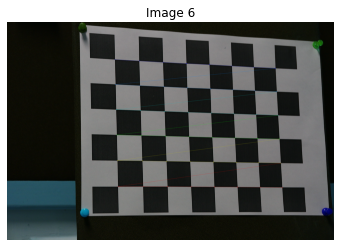

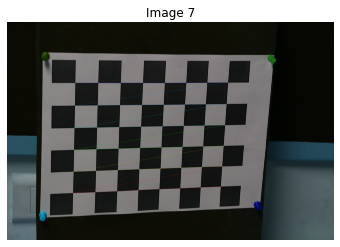

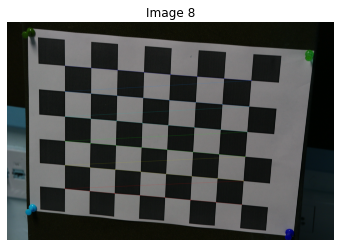

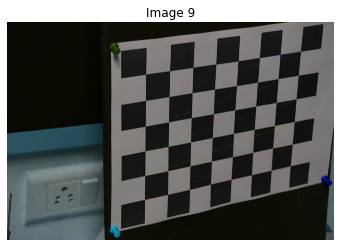

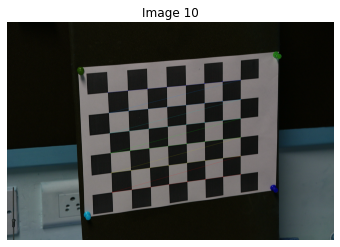

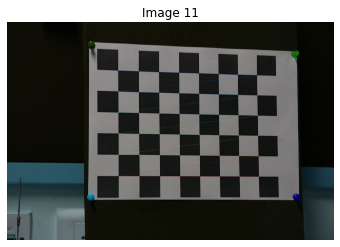

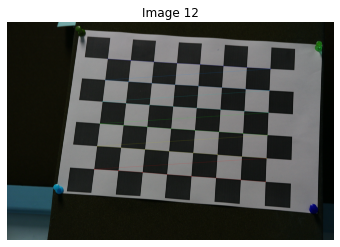

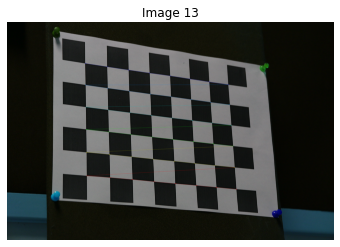

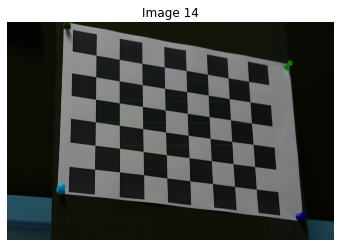

In [16]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# grid size
r, c = 8, 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ...., (6,5,0)
objp = np.zeros((r*c, 3), np.float32)
objp[:,:2] = np.mgrid[0:r,0:c].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

print("Loading images...")

# get images
images = []
for i in range(56, 71):
    img = cv2.imread(f"q1/Zhangs/IMG_54{i}.JPG")
    images.append(img)

# populate object and image points
for i, img in enumerate(images):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    found, corners = cv2.findChessboardCorners(gray, (r,c), None)

    # If found, add object points, image points (after refining them)
    if found:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (r,c), corners2, found)
        plt.title(f"Image {i}")
        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [17]:
# Find camera matrix K
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("K = \n", K)

K = 
 [[1.36415095e+04 0.00000000e+00 3.31635924e+03]
 [0.00000000e+00 1.36632518e+04 1.50037425e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


---
### 4.2 Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. You should first estimate the fundamental matrix from these two images.

<img src="./q2/img1.jpg" alt="image 1" width="400"/>
<img src="./q2/img2.jpg" alt="image 2" width="400"/>


Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. For this question you will need to compute the F matrix on your own without using inbuilt functions. 

In [9]:
image1_points = annotate('q2/img1.jpg')

371.1129032258064 98.49354838709678
497.27777777777777 109.96308243727606
617.7078853046594 137.48996415770614
725.5215053763441 178.78028673835126
805.8082437275984 220.0706093189965
871.18458781362 264.80179211469533
351.6146953405018 593.9774193548387
553.4784946236559 626.0921146953406
605.0913978494623 630.6799283154122
732.4032258064515 646.7372759856631
774.8405017921148 652.4720430107527
858.568100358423 658.2068100358423
170.39605734767025 538.9236559139786
90.10931899641577 119.13870967741946
191.0412186379928 148.9594982078853
325.23476702508964 318.7086021505377
357.34946236559136 288.8878136200717
398.6397849462365 265.94874551971327
430.7544802867383 252.18530465949823
499.57168458781365 261.3609318996416
578.7114695340501 282.0060931899642
599.3566308243728 301.5043010752688


In [23]:
# Obtained from manual annotation above
image1_points = np.array([[371.1129032258064, 98.49354838709678],
    [497.27777777777777, 109.96308243727606],
    [617.7078853046594, 137.48996415770614],
    [725.5215053763441, 178.78028673835126],
    [805.8082437275984, 220.0706093189965],
    [871.18458781362, 264.80179211469533],
    [351.6146953405018, 593.9774193548387],
    [553.4784946236559, 626.0921146953406],
    [605.0913978494623, 630.6799283154122],
    [732.4032258064515, 646.7372759856631],
    [774.8405017921148, 652.4720430107527],
    [858.568100358423, 658.2068100358423],
    [170.39605734767025, 538.9236559139786],
    [90.10931899641577, 119.13870967741946],
    [191.0412186379928, 148.9594982078853],
    [325.23476702508964, 318.7086021505377],
    [357.34946236559136, 288.8878136200717],
    [398.6397849462365, 265.94874551971327],
    [430.7544802867383, 252.18530465949823],
    [499.57168458781365, 261.3609318996416],
    [578.7114695340501, 282.0060931899642],
    [599.3566308243728, 301.5043010752688]])
print(image1_points)

[[371.11290323  98.49354839]
 [497.27777778 109.96308244]
 [617.7078853  137.48996416]
 [725.52150538 178.78028674]
 [805.80824373 220.07060932]
 [871.18458781 264.80179211]
 [351.61469534 593.97741935]
 [553.47849462 626.0921147 ]
 [605.09139785 630.67992832]
 [732.40322581 646.73727599]
 [774.84050179 652.47204301]
 [858.56810036 658.20681004]
 [170.39605735 538.92365591]
 [ 90.109319   119.13870968]
 [191.04121864 148.95949821]
 [325.23476703 318.70860215]
 [357.34946237 288.88781362]
 [398.63978495 265.94874552]
 [430.75448029 252.18530466]
 [499.57168459 261.3609319 ]
 [578.71146953 282.00609319]
 [599.35663082 301.50430108]]


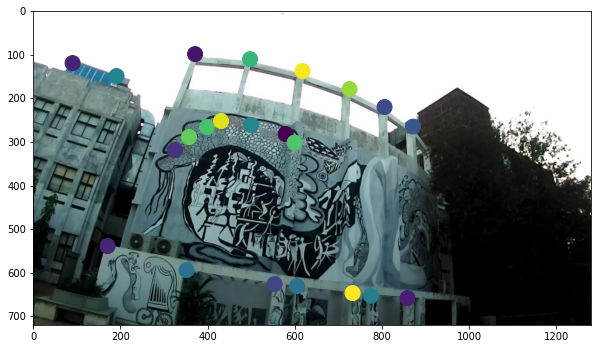

In [24]:
show2DProjections(image1_points, 'q2/img1.jpg')

In [18]:
image2_points = annotate('q2/img2.jpg')

In [25]:
# Obtained from manual annotation above
image2_points = np.array([[391.75806451612897, 111.110035842294],
    [474.33870967741933, 74.40752688172051],
    [584.4462365591398, 51.468458781362074],
    [704.8763440860214, 41.145878136200736],
    [827.600358422939, 49.174551971326196],
    [945.736559139785, 69.81971326164876],
    [313.76523297491036, 496.48637992831544],
    [458.2813620071684, 501.07419354838714],
    [507.600358422939, 506.8089605734767],
    [653.263440860215, 513.6906810035842],
    [714.0519713261649, 514.8376344086022],
    [858.568100358423, 521.7193548387097],
    [222.0089605734767, 479.28207885304664],
    [247.24193548387098, 209.74802867383517],
    [324.0878136200717, 208.60107526881723],
    [357.34946236559136, 298.0634408602151],
    [376.847670250896, 262.50788530465957],
    [402.0806451612903, 236.1279569892473],
    [426.1666666666667, 215.48279569892475],
    [478.926523297491, 199.42544802867394],
    [544.3028673835124, 191.39677419354848],
    [548.8906810035842, 204.01326164874558]])
print(image2_points)

[[391.75806452 111.11003584]
 [474.33870968  74.40752688]
 [584.44623656  51.46845878]
 [704.87634409  41.14587814]
 [827.60035842  49.17455197]
 [945.73655914  69.81971326]
 [313.76523297 496.48637993]
 [458.28136201 501.07419355]
 [507.60035842 506.80896057]
 [653.26344086 513.690681  ]
 [714.05197133 514.83763441]
 [858.56810036 521.71935484]
 [222.00896057 479.28207885]
 [247.24193548 209.74802867]
 [324.08781362 208.60107527]
 [357.34946237 298.06344086]
 [376.84767025 262.5078853 ]
 [402.08064516 236.12795699]
 [426.16666667 215.4827957 ]
 [478.9265233  199.42544803]
 [544.30286738 191.39677419]
 [548.890681   204.01326165]]


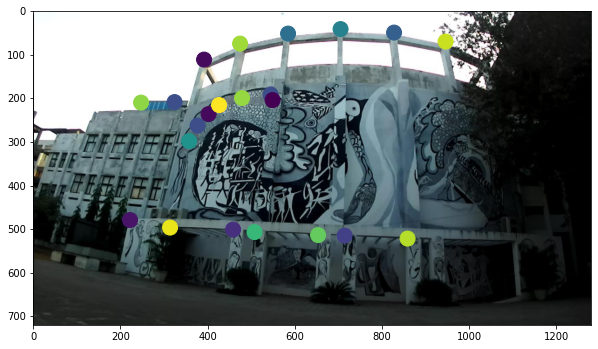

In [26]:
show2DProjections(image2_points, 'q2/img2.jpg')

In [27]:
def estF(p1, p2):    
    A = []    
    for (x1i, y1i, _), (x2i, y2i, _) in zip(p1, p2):
        A.append([x1i * x2i, x1i * y2i, x1i, y1i * x2i, y1i * y2i, y1i, x2i, y2i, 1])
        
    A = np.array(A)
    U, D, VT = np.linalg.svd(A)
    F = VT[-1, :].reshape(3, 3)
    
    U, D, VT = np.linalg.svd(F)
    D[-1] = 0
    F = U @ np.diag(D) @ VT
    F /= F[-1, -1]
    
    return F

In [28]:
def estF_normalized(p1, p2):
    p1_hom = np.array(copy.deepcopy(p1))
    p1_hom = np.hstack((p1_hom, np.ones((p1_hom.shape[0], 1)))).T
    p2_hom = np.array(copy.deepcopy(p2))
    p2_hom = np.hstack((p2_hom, np.ones((p2_hom.shape[0], 1)))).T
    
    mean_1 = np.mean(p1_hom[:2],axis=1)
    S1 = np.sqrt(2) / np.std(p1_hom[:2])
    T1 = np.array([[S1,0,-S1 * mean_1[0]], [0,S1,-S1*mean_1[1]],[0,0,1]])
    p1_hom = T1 @ p1_hom
    
    mean_2 = np.mean(p2_hom[:2],axis=1)
    S2 = np.sqrt(2) / np.std(p2_hom[:2])
    T2 = np.array([[S2,0,-S2 * mean_2[0]], [0,S2,-S2*mean_2[1]],[0,0,1]])
    p2_hom = T2 @ p2_hom

    # compute F with the normalized coordinates
    F = estF(p1_hom.T, p2_hom.T)

    # reverse normalization
    F = T1.T @ F @ T2
    F /= F[-1, -1]
    
    return F

In [29]:
img1Pts = np.array(image1_points)
img2Pts = np.array(image2_points)
F = estF_normalized(img1Pts, img2Pts)

# F = np.array([[-1.29750186e-06,  8.07894025e-07, 1.84071967e-03],
# [3.54098411e-06,  1.05620725e-06, -8.90168709e-03],
# [-3.29878312e-03,  5.14822628e-03,  1.00000000e+00]])
# F = F.T

print(F)

[[-1.58440783e-06  2.57400020e-06 -2.94423124e-03]
 [ 2.07459426e-06  7.75116288e-07  5.05061004e-03]
 [ 1.50714562e-03 -8.69242904e-03  1.00000000e+00]]


In [30]:
def epLines(F, img1Path, img2Path, pts1, pts2):
    img1 = mpimg.imread(img1Path)
    img2 = mpimg.imread(img2Path)
    homoPts1 = np.hstack([pts1, np.ones((pts1.shape[0], 1))]).T
    lines = F @ homoPts1
    lineYInter = np.vstack([np.zeros((1, pts1.shape[0])), -lines[2, :] / lines[1, :]])
    lineXInter = np.vstack([img2.shape[1] * np.ones((1, pts1.shape[0])), (-lines[2, :] - lines[0, :] * img2.shape[1]) / lines[1, :]])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    for i in range(lineYInter.shape[1]):
        color = [np.random.randint(1, 255), np.random.randint(1, 255), np.random.randint(1, 255)]
        img1 = cv2.circle(img1, tuple(pts1[i, :].astype(int)), 10, color, -1)
        img2 = cv2.circle(img2, tuple(pts2[i, :].astype(int)), 10, color, -1)
        img2 = cv2.line(img2, tuple(lineYInter[:, i].astype(int)), tuple(lineXInter[:, i].astype(int)), color, 4)
        
    ax1.imshow(img1)
    ax2.imshow(img2)
    plt.show()

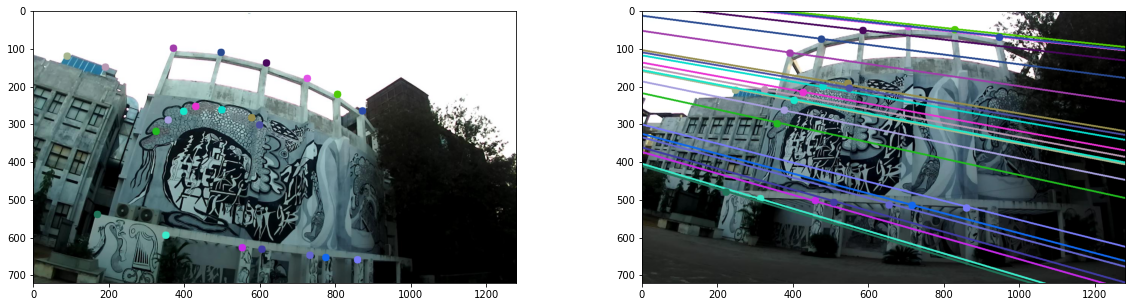

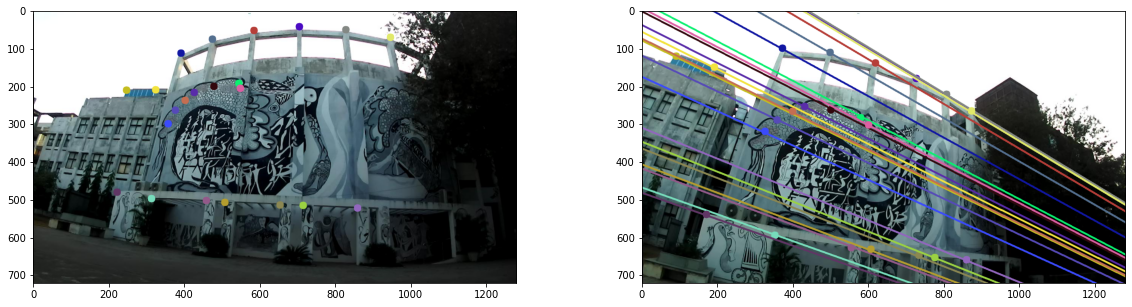

In [31]:
%matplotlib inline
epLines(F.T, 'q2/img1.jpg', 'q2/img2.jpg', img1Pts, img2Pts)
epLines(F, 'q2/img2.jpg', 'q2/img1.jpg', img2Pts, img1Pts)

**Provide a clear explanation on your approach for both this task and the next**

The first step is to estimate the Fundamental matrix, F. To do this, we require atleast 8 correspondences between the two images as each correspondence gives us 1 equation and there are 8 unknown parameters (not 9 as 1 is lost due to homogeneous coordinates). We find these correspondences by manually annotating both images. Then we apply the 8 point algorithm to obtain an estimate for F. This algorithm involves rearranging the x'<sup>T</sup>Fx = 0 formula in the form Af = 0 so that we can use the SVD method to obtain f which is F as an array. Then we divide F by the last homogeneous parameter to normalize it, take its SVD, set the last singular value to 0 to make F of rank 2 and obtain F by multiplying the three decomposed matrices.

Once we have F, we can easily obtain the epipolar lines by simply multiplying F with the points for which we want the lines. For obtaining the epipolar lines of the 1st image on the second image, we use the transpose of F instead of F.

#### Task 2
Report the location of the epipoles. Mathematically find the epipoles and verify that the lines intersect at the epipole.

Multiplying F with an epipole gives us 0 which tells us that the epipoles lie in the nullspace of F. Thus, we obtain the nullspace of F by taking the last column of the V matrix from the SVD decomposition as it corresponds to the singular value of 0. We apply the same process for F transpose to obtain the epipole on the 1st image.

In [27]:
def nullSpace(A):
    U, D, VT = np.linalg.svd(A)
    vec = VT.T[:, -1]
    return np.array([vec[0] / vec[2], vec[1] / vec[2]])

In [28]:
# Epipole on first image
e1 = nullSpace(F.T)
# Epipole on second image
e2 = nullSpace(F)

print("Epipole on first image:", e1)
print("Epipole on second image:", e2)

Epipole on first image: [-1009.68708714  -169.87377186]
Epipole on second image: [-206.54482413  251.36009795]


For verification that the epipolar lines intersect at the epipole, we plug in the epipole into the lines' equations'. If they do intersect at the epipole, then the resultant of all the equations should be 0 which turns out to be the case for both images.

In [57]:
def verify(F, pts, epi):
    homoPts = np.hstack([pts, np.ones((pts.shape[0], 1))]).T
    lines = F @ homoPts
    print((lines[0, :] * epi[0] + lines[1, :] * epi[1] + lines[2, :]).astype(int))

print("Image 2 Verification: ")
verify(F.T, img1Pts, e2)
print("Image 1 Verification: ")
verify(F, img2Pts, e1)

Image 2 Verification: 
[0 0 0 0 0 0 0 0]
Image 1 Verification: 
[0 0 0 0 0 0 0 0]


____
### 4.3 Drawing a bounding box around a car and localizing it in the camera frame
You’ve been provided with an image, also taken from a self-driving car, that shows another car in front. The camera has been placed on top of the car, 1.65 m from the ground, and assume the image plane is perfectly perpendicular to the ground. K is provided to you. Your task is to draw a 3D-bounding box around the car in front as shown. Your approach should be to place eight points in the 3D world such that they surround all the corners of the car, then project them onto the image, and connect the projected image points using lines. You might have to apply a small 5° rotation about the vertical axis to align the box perfectly. Rough dimensions of the car - h: 1.38 m, w: 1.51, l: 4.10. (Hint: Fix a point on the ground as your world origin.). Also estimate the approximate translation vector to the mid-point of the two rear wheels of the car in the camera frame.

![Kitti car](./q3/image.png)

## Working

![Part 1](./q3/working1.jpeg)
![Part 2](./q3/working1.jpeg)

In [79]:
originCam = annotate('q3/image.png')

[]
754.0483870967741 263.7597177419356


In [29]:
# Obtained from manual annotation above
originCam = np.array([754.0483870967741, 263.7597177419356])
print(originCam)

[754.0483871  263.75971774]


In [30]:
from matplotlib import image
%matplotlib inline

def project(boxCoords2D): 
    boxCoords2D = np.vstack([boxCoords2D, boxCoords2D[4, :], 
                             boxCoords2D[3, :], boxCoords2D[0, :], boxCoords2D[5, :], 
                             boxCoords2D[6, :], boxCoords2D[1, :],
                             boxCoords2D[2, :], boxCoords2D[7, :]
                            ])
    plt.figure(figsize=[20, 20])
    img = image.imread('q3/image.png')
    plt.plot(boxCoords2D[:, 0].T, boxCoords2D[:, 1].T, color="blue", linewidth=2)
    plt.imshow(img)
    
    plt.show()

In [31]:
def getCalib():
    path = 'q3/K.txt'
    K = []
    
    with open(path) as f:
        contents = f.read()
        rows = contents[5:-2].split(';')
        for row in rows:
            elems = np.array(row.split(',')).astype(float)
            K.append(elems)
        
        K = np.array(K)
    
    return K

In [32]:
def transform(boxCoords3D):
    K = getCalib()
    rot = -2.5 * np.pi / 180
    R = [[np.cos(rot), 0, np.sin(rot)],
        [0, 1, 0],
        [-np.sin(rot), 0, np.cos(rot)]]
    t = np.array([2.622, 1.65, 13.095]).reshape((3, 1))

    boxCoords2D = K @ (R @ boxCoords3D + t)
    div = np.array(([boxCoords2D[2, :]] * 3))
    boxCoords2D = boxCoords2D / div
       
    return boxCoords2D.T[:, :2]

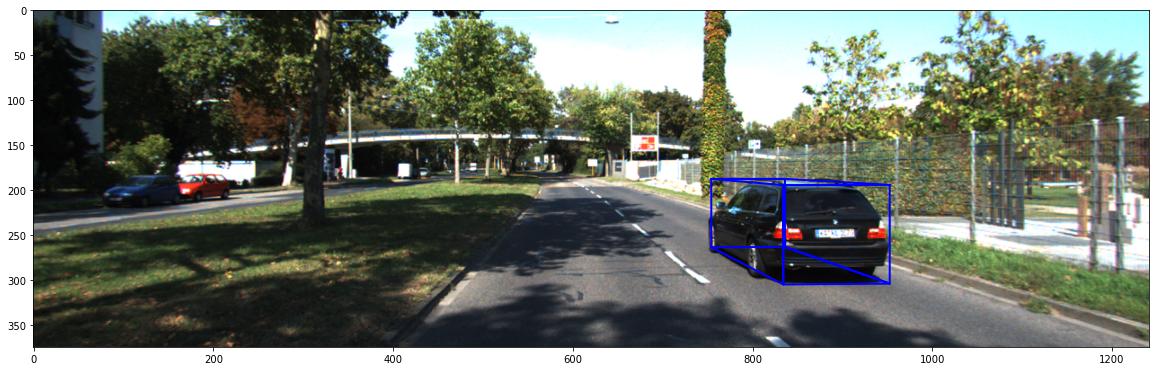

In [33]:
# Assuming X from left to right
# Y from top to bottom
# Z from back to front
# Origin at bottom-left-back box coordinate

dims = [1.51, 1.38, 4.1]
boxCoords3D = np.array([[0, 0, 0],
               [dims[0], 0, 0],
               [dims[0], 0, -dims[2]],
               [0, 0, -dims[2]],
               [0, -dims[1], -dims[2]],
               [0, -dims[1], 0],
               [dims[0], -dims[1], 0],
               [dims[0], -dims[1], -dims[2]]
              ])


boxCoords2D = transform(boxCoords3D.T)
project(boxCoords2D)

In [43]:
t = np.array([2.622, 1.65, 13.095]).reshape((3, 1))
tleft = copy.deepcopy(t)
tleft[2] = t[2] - dims[2]

tright = copy.deepcopy(tleft)
tright[0] = tleft[0] + dims[0]

tmid = (tleft + tright) / 2
print("Translation vector to midpoint of rear tyres = \n", tmid)

Translation vector to midpoint of rear tyres = 
 [[3.377]
 [1.65 ]
 [8.995]]
